# Computer Vision using Tenserflow
In this notebook, I'll take a look at a scenario where I can recognize different items of clothing, trained from a dataset containing 10 different types. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time

import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import seaborn as sns

1.13.1


## Loading dataset

Let's start with our import of TensorFlow. The Fashion MNIST data is available directly in the tf.keras datasets API. 

In [2]:
#load the data
mnist = tf.keras.datasets.fashion_mnist

Calling load_data on this object will give you two sets of two lists, these will be the training and testing values for the graphics that contain the clothing items and their labels.


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


This is a pullover. All of the values in the number are between 0 and 255. If we are training a neural network, for various reasons it's easier if we normalize them.

In [4]:
# normalization
X_train  = X_train / 255.0
X_test = X_test / 255.0

# scaling
X_train = (X_train - np.min(X_train, 0)) / (np.max(X_train, 0) + 0.0001)

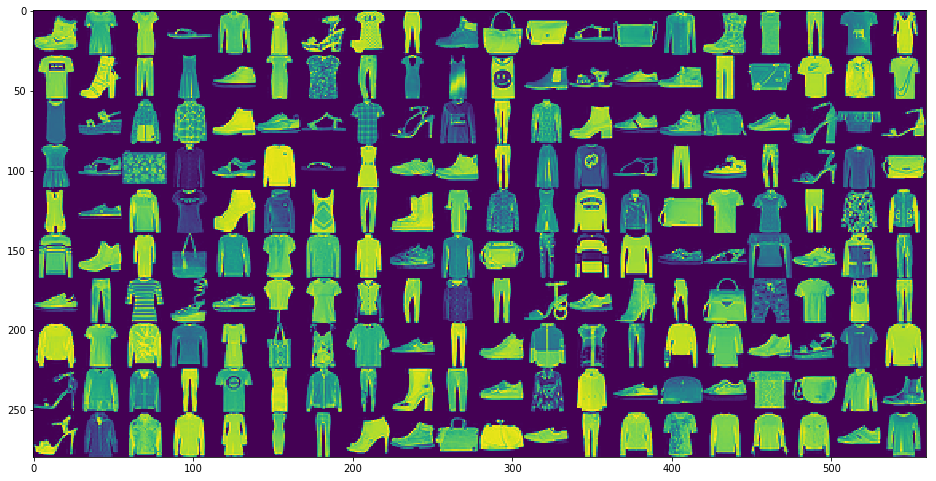

In [5]:
# fucntion to retrieve images from train set
def get_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

plt.figure(figsize=(16,20))
plt.imshow(get_image(X_train))

Scikit-learn expects 2d num arrays for the training dataset for a fit function. Our dataset is a 3d array. I need to reshape the array into a 2d.

In [6]:
# reshaping 3d array into 2d
def to_2d(X):
    nsamples, nx, ny = X.shape
    X_2d = X.reshape((nsamples,nx*ny))
    return X_2d

X_train = to_2d(X_train)
X_test = to_2d(X_test)

# Logistic Classification on Raw Pixel

In [7]:
# initialize model
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=100)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(lr)
raw_pixel_classifier.fit(X_train, y_train)

y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(y_test, y_pred)))


Logistic regression using raw pixel features:
             precision    recall  f1-score   support

          0       0.80      0.81      0.80      1000
          1       0.97      0.96      0.97      1000
          2       0.74      0.72      0.73      1000
          3       0.84      0.86      0.85      1000
          4       0.72      0.78      0.75      1000
          5       0.94      0.93      0.93      1000
          6       0.62      0.55      0.59      1000
          7       0.91      0.93      0.92      1000
          8       0.93      0.95      0.94      1000
          9       0.95      0.94      0.94      1000

avg / total       0.84      0.84      0.84     10000




# RBM & Logistic Classifier
Here I'll build a classification pipeline with a BernoulliRBM feature extractor and a LogisticRegression classifier. 

In [8]:
# initialize model
rbm = BernoulliRBM(n_components=100, learning_rate=0.1, random_state=42, verbose=True)
lr.C = 0.1
# Create pipeline
rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', lr)])

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, y_train)

# Evaluation
y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(y_test, y_pred)))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -224.61, time = 21.59s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -221.78, time = 23.98s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -220.90, time = 24.36s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -216.08, time = 23.55s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -220.56, time = 23.21s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -218.56, time = 23.22s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -218.94, time = 23.18s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -212.38, time = 23.26s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -212.61, time = 35.54s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -212.38, time = 340.44s
Logistic regression using RBM features:
             precision    recall  f1-score   support

          0       0.73      0.78      0.76      1000
          1       0.98      0.92      0.95      1000
          2       0.52      0.64      0.58      1000
          3       0.74      0.83   

<function matplotlib.pyplot.show(*args, **kw)>

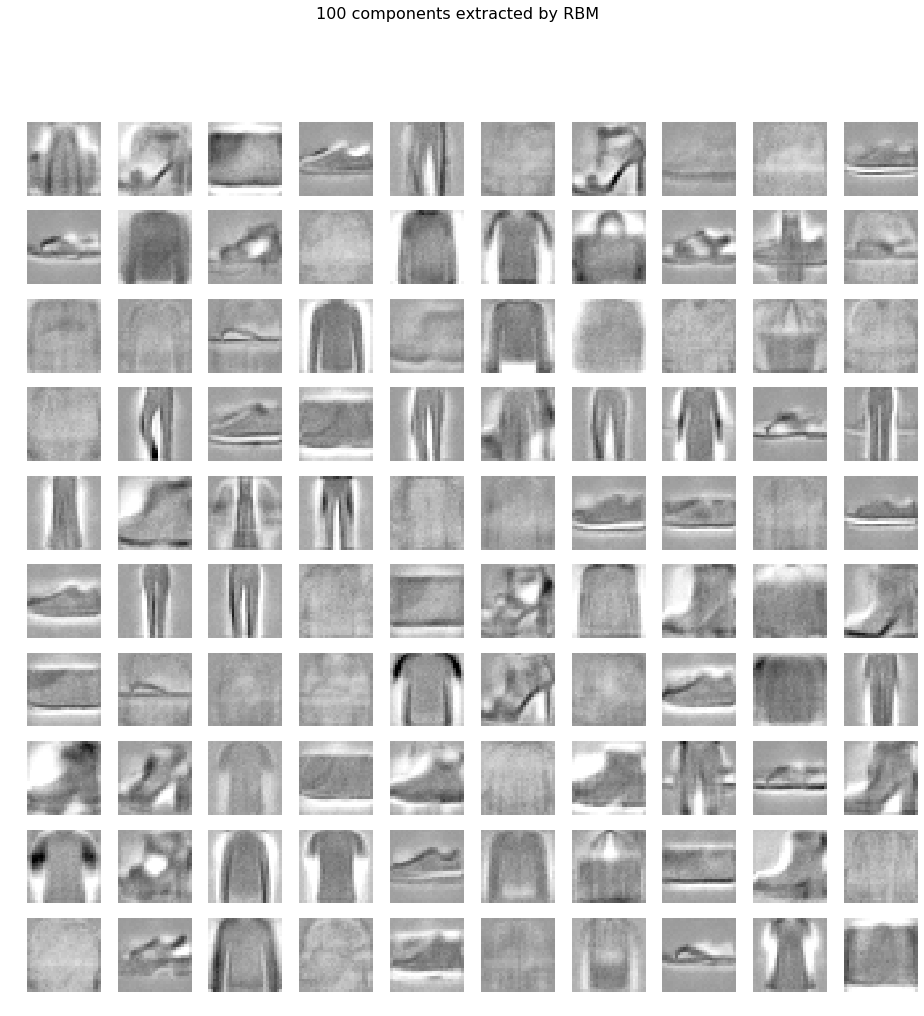

In [9]:
# Retrieve the RBM components
plt.figure(figsize=(16, 16))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.Greys,
               interpolation='nearest', vmin=-2.0, vmax=2.0)
    plt.axis('off')
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.show

In [10]:
# perform a grid search on the learning rate, number of
# iterations, and number of components on the RBM and
# C for Logistic Regression
#params = {"rbm__learning_rate": [0.1, 0.01, 0.001],
#          "rbm__n_iter": [20, 40, 80],
#          "rbm__n_components": [50, 100, 200],
#          "logistic__C": [1.0, 10.0, 100.0]}

#rbm = BernoulliRBM()
#lr = LogisticRegression()
#rbm_features_classifier = Pipeline([("rbm", rbm), ("logistic", lr)])

# perform a grid search over the parameter
#start = time.time()
#gs = GridSearchCV(rbm_features_classifier, params, n_jobs = -1, verbose = 1)
#gs.fit(X_train, y_train)
#print("\ndone in %0.3fs" % (time.time() - start))
#print("best score: %0.3f" % (gs.best_score_))
#bestParams = gs.best_estimator_.get_params()
#print(bestParams)

# Conclusion
Logistic Classifier alone did a good job compared to the result after RBM feature extraction. I doubt that RBM is not helpful at all. Probably, using GridSearchCV I may get the best parameters for BernoulliRBM to extract features and pass them to Logistic Classifier in order to improve the model and get better accuracy.